In [1]:
# Means clustering : https://www.kaggle.com/code/satishgunjal/tutorial-k-means-clustering
# plotting the clusters :  https://koalatea.io/python-plot-kmeans-clusters/
import pandas as pd
import numpy  as np
import json
import math 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
hfont = {'fontname':'Monaco'}

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,4]
plt.rcParams['font.size'] =  13 

In [2]:
# read in the experiment data for analysis 
analysis_df = pd.read_pickle('traceroute.pickle')

#drop the rows with null values in avg_rtt
nan_rows = analysis_df[analysis_df['avg_rtt'].isnull()]
analysis_df = analysis_df.dropna(subset=['avg_rtt'])

#extracting the date from the timestamp
analysis_df['date'] = analysis_df['new_time'].dt.date

Text(0, 0.5, 'avg_rtt(ms)')

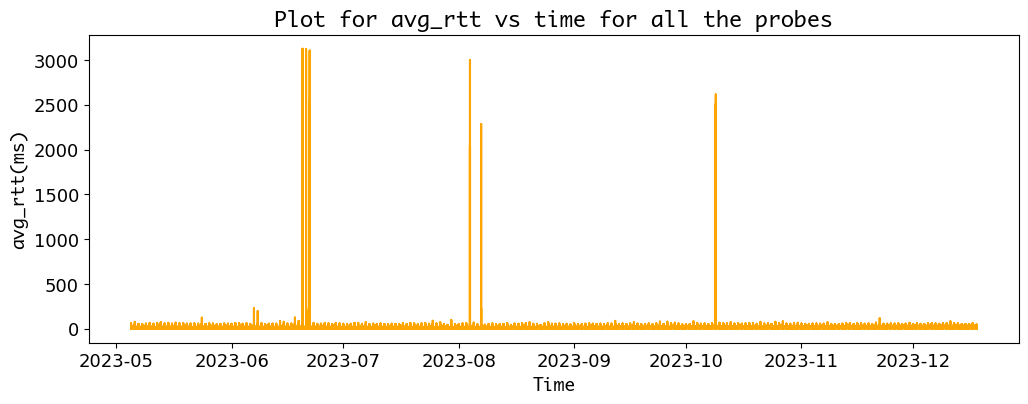

In [3]:
plt.plot(analysis_df['date'],analysis_df['avg_rtt'],'-', color='orange')
plt.title('Plot for avg_rtt vs time for all the probes', **hfont )
plt.xlabel('Time', **hfont)
plt.ylabel('avg_rtt(ms)', **hfont)

In [4]:
#plot the longest distance probe 
plot_df = analysis_df[(analysis_df['prb_id'] == 33627) & (analysis_df['dst_id'] == '1004200')]
#plot_df.plot(x='date', y='avg_rtt', kind='line', figsize=(15, 5), title='RTT from 33627 to 1004200')

<Axes: title={'center': 'RTT from 33627 to 1004200'}, xlabel='date', ylabel='sum_rtt'>

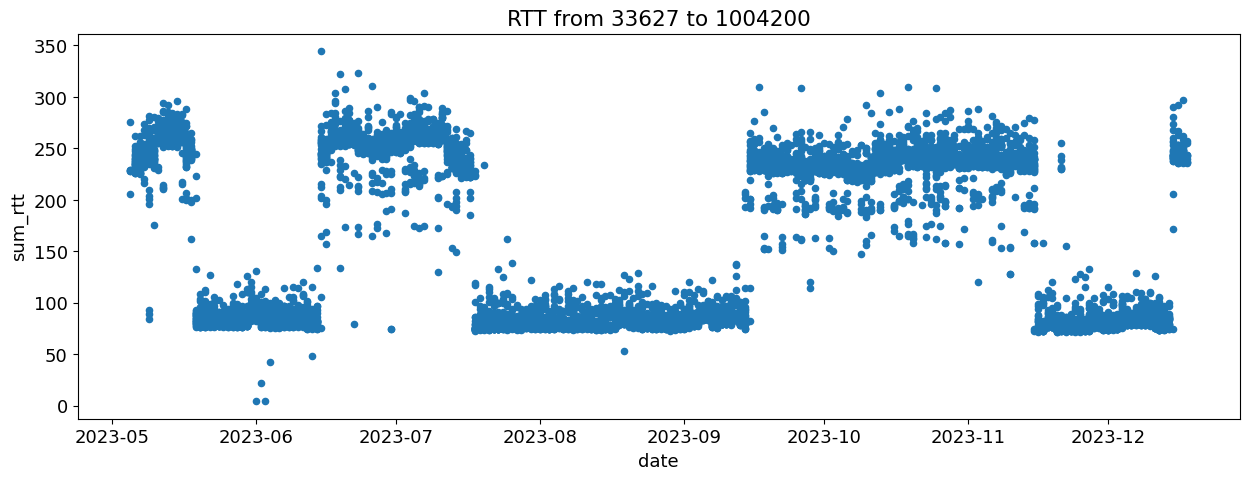

In [5]:
sum_data = plot_df.groupby(['date', plot_df.index])['avg_rtt'].sum().reset_index()
sum_data = sum_data.rename(columns={'avg_rtt': 'sum_rtt'})
sum_data.plot(x='date', y='sum_rtt', kind='scatter', figsize=(15, 5), title='RTT from 33627 to 1004200')

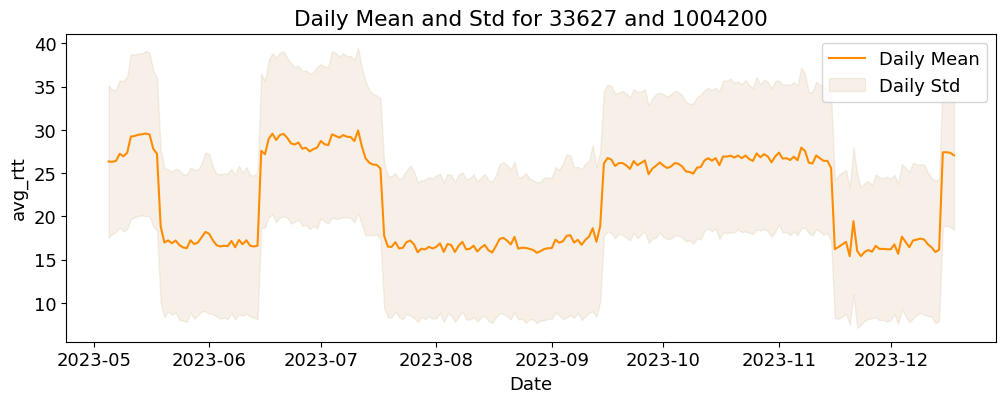

In [6]:
day_gp = plot_df.groupby(['date','prb_id','dst_id'])
#print(day_gp.groups.keys())

daily_mean = day_gp['avg_rtt'].mean().reset_index()
daily_std = day_gp['avg_rtt'].std().reset_index()


plt.plot(daily_mean['date'], daily_mean['avg_rtt'], label='Daily Mean',color='darkorange')
plt.fill_between(daily_mean['date'], daily_mean['avg_rtt'] - (daily_std['avg_rtt']/2), daily_mean['avg_rtt'] + (daily_std['avg_rtt']/2), alpha=0.2, label='Daily Std',color='tan')
plt.xlabel('Date')
plt.ylabel('avg_rtt')
plt.title('Daily Mean and Std for 33627 and 1004200')
plt.legend()
plt.show()



In [7]:
def unique_ip_df(source,destination,start_time,end_time):
    ip_df = analysis_df[(analysis_df['prb_id'] == source) & (analysis_df['dst_id'] == destination)]

    # Get the unique traceroute indices
    indices = ip_df.index.unique()

    exp_no = []
    hop_number = []
    unique_ips = []
    avg_rtt = []

    #Create an empty DataFrame
    df = pd.DataFrame(columns=['Index', 'Hop', 'IP'])
    data_list = [] 


    for idx in indices:
        group = ip_df[ip_df.index == idx]
        timew = group['new_time'].values[0]
        target_date = np.datetime64(start_time)
        end_date = np.datetime64(end_time)
        
        if  target_date <= timew < end_date:
            hops = group['hop']
            rtt = group['avg_rtt']
            ip = group['unique_ips']
            
            exp_no.append(idx)
            hop_number.append(hops)
            unique_ips.append(ip)
            
            # Iterate through the hops and IPs and add them to the DataFrame
            for hop, unique_ip in zip(hops, ip):
                data_list.append({'Index': idx, 'Hop': hop, 'IP': unique_ip})

            
            
    # Create a DataFrame from the list of dictionaries
    route_df = pd.DataFrame(data_list)
    
    return route_df

In [8]:
timeband1_df = unique_ip_df(33627,'1004200','2023-06-15','2023-07-15')  
timeband2_df = unique_ip_df(33627,'1004200','2023-07-15','2023-08-15')  

In [9]:
def find_distinct(df):
    # Group by 'Hop' and concatenate the lists of IPs within each group
    grouped = df.groupby('Hop')['IP'].sum()

    # Convert the lists of IPs to sets to get unique IPs at each hop
    unique_ips = grouped.apply(set)

    # Reset the index to make it a DataFrame
    unique_ips_df = unique_ips.reset_index()

    # Rename the columns
    unique_ips_df.columns = ['Hop', 'Unique_IPs']

    # Print the result
    print(unique_ips_df)

In [10]:
timeOne_df = find_distinct(timeband1_df)
print(timeOne_df)

   Hop                           Unique_IPs
0    1                  {None, 192.168.1.1}
1    2                       {81.46.38.142}
2    3                        {81.46.34.81}
3    4                 {81.46.34.133, None}
4    5                   {None, 80.58.96.1}
5    6  {None, 81.41.250.113, 80.58.106.57}
6    7                  {None, 81.46.1.129}
7    8  {88.24.67.177, 81.41.250.117, None}
8   10                       {88.24.67.177}
None


In [11]:

print(find_distinct(timeband2_df))

   Hop                           Unique_IPs
0    1                  {None, 192.168.1.1}
1    2                       {81.46.38.142}
2    3                        {81.46.34.81}
3    4                 {81.46.34.133, None}
4    5                   {None, 80.58.96.1}
5    6  {None, 80.58.106.57, 81.41.250.121}
6    7                        {81.46.1.129}
7    8  {None, 81.41.250.117, 88.24.67.177}
8   10                       {88.24.67.177}
None


In [12]:
from sklearn.cluster import KMeans
def ideal_k(df, n):
    # Extract the 'Mean_rtt' column from the DataFrame
    mean_latency_data = df['Mean_rtt'].values.reshape(-1, 1)
    
    clustering_score = []
    for i in range(1, n):

        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=i,init="random",random_state=0)
        kmeans.fit(mean_latency_data)
        # inertia_ = Sum of squared distances of samples to their closest cluster center.
        clustering_score.append(math.sqrt(kmeans.inertia_/len(mean_latency_data))) 
        
    plt.plot(range(1, n), clustering_score)
    plt.scatter(5,clustering_score[4], s = 200, c = 'red', marker='*')
    plt.title('The Elbow Method')
    plt.xlabel('No. of Clusters')
    plt.ylabel('Clustering Score')
    plt.show()

In [13]:
#getting the mean value of the rtt for each day for probe destination pair
mean_ping_per_day = analysis_df.groupby(['date', 'prb_id', 'dst_id','new_time'])['avg_rtt'].mean().reset_index()

#collecting the final values in a dataframe
mean_df = pd.DataFrame({
    'Source_Server': mean_ping_per_day['prb_id'],
    'Destination_Server': mean_ping_per_day['dst_id'],
    'Original_Date': mean_ping_per_day['new_time'],
    'Date': mean_ping_per_day['date'],
    'Mean_rtt': mean_ping_per_day['avg_rtt']
})

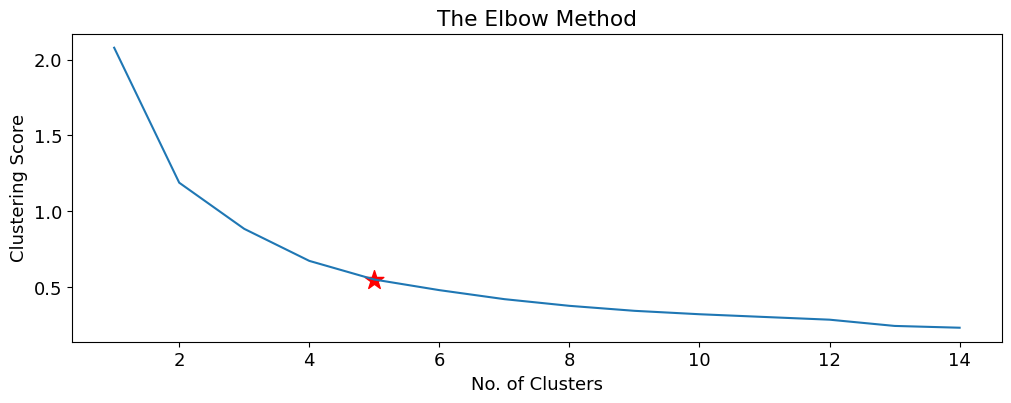

In [14]:
kmeans_df = mean_df[(mean_df['Source_Server'] == 33627) & (mean_df['Destination_Server'] == '26072')]
ideal_k(kmeans_df, 15)

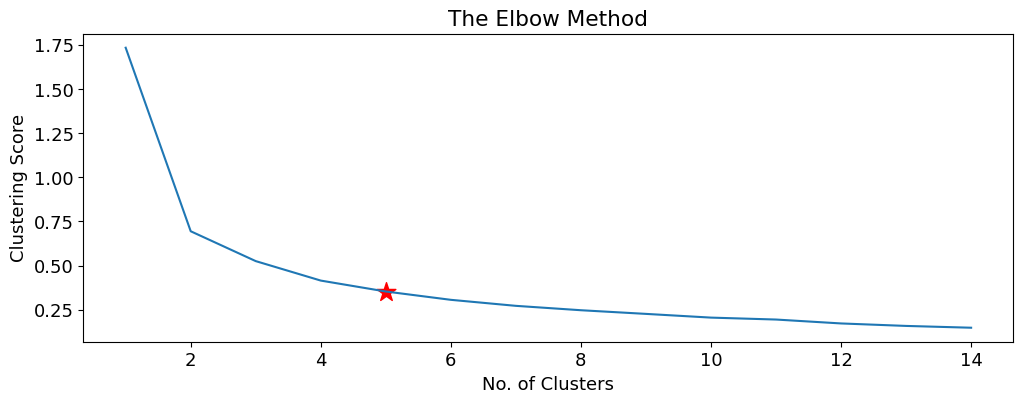

In [15]:
source2 = 15118
destination2 = '26072'
kmeans_df2 = mean_df[(mean_df['Source_Server'] == source2) & (mean_df['Destination_Server'] == destination2)]
ideal_k(kmeans_df2, 15)

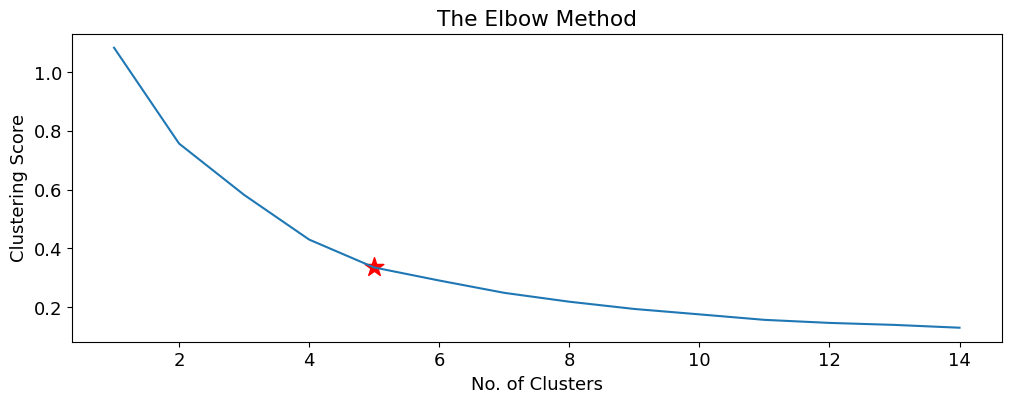

In [16]:
source3 = 51265
destination3 = '15632'
kmeans_df3 = mean_df[(mean_df['Source_Server'] == source3) & (mean_df['Destination_Server'] == destination3)]
ideal_k(kmeans_df3, 15)

/var/folders/fn/t1h5mchj4qg8nfdt2p1xfmwh0000gn/T/ipykernel_10360/1689219284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_mean_values['cluster'] = kmeans.fit_predict(daily_mean_values[['avg_rtt']])


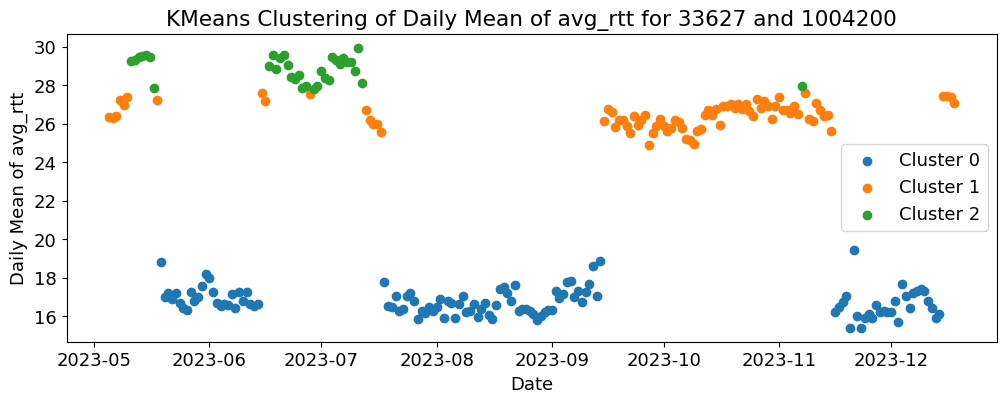

In [17]:
daily_mean_values = daily_mean[['prb_id', 'dst_id', 'date', 'avg_rtt']]

# Apply KMeans with assumed K=3
kmeans = KMeans(n_clusters=3, random_state=42)
daily_mean_values['cluster'] = kmeans.fit_predict(daily_mean_values[['avg_rtt']])

# Extract cluster centroids and labels
cluster_centroids = kmeans.cluster_centers_
cluster_labels = kmeans.fit_predict(daily_mean_values[['avg_rtt']])

# Loop through clusters
for cluster_num in range(3):
    cluster_data = daily_mean_values[daily_mean_values['cluster'] == cluster_num]
    plt.scatter(cluster_data['date'], cluster_data['avg_rtt'], label=f'Cluster {cluster_num}')

plt.xlabel('Date')
plt.ylabel('Daily Mean of avg_rtt')
plt.title('KMeans Clustering of Daily Mean of avg_rtt for 33627 and 1004200')
plt.legend()
plt.show()

In [18]:
# Print the cluster labels and centroids
print("Cluster Labels:")
print(cluster_labels)

print("Cluster Centroids:")
print(cluster_centroids)

Cluster Labels:
[1 1 1 1 1 1 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1]
Cluster Centroids:
[[16.77108031]
 [26.45471386]
 [28.85484728]]
